In [ ]:
! pip install -q datasets tqdm

     |████████████████████████████████| 451 kB 24.5 MB/s 
     |████████████████████████████████| 115 kB 61.7 MB/s 
     |████████████████████████████████| 212 kB 82.0 MB/s 
     |████████████████████████████████| 182 kB 81.5 MB/s 
     |████████████████████████████████| 127 kB 65.3 MB/s 


In [ ]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
!rm -r ./images/

rm: cannot remove './images/': No such file or directory


In [ ]:
import collections
import random
import os
import time
import json
from PIL import Image
import io
import urllib
import uuid
from concurrent.futures import ThreadPoolExecutor
from functools import partial

import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# iso639_3_letter_code = "hau"
# iso639_3_letter_code = "tha"
iso639_3_letter_code = "kir"

# Download the language specific dataset from HF.
dataset = load_dataset("sil-ai/bloom-captioning", iso639_3_letter_code, 
                       use_auth_token=True, download_mode='force_redownload')

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset bloom-captioning downloaded and prepared to /root/.cache/huggingface/datasets/sil-ai___bloom-captioning/kir/0.0.0/8efe15718b4a50170c9add75b453aec13ec1c5216111d21815428536fe5913ca. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

In [ ]:
dataset['train']

Dataset({
    features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story'],
    num_rows: 3919
})

In [ ]:
dataset['train'][0]

{'image_id': '2888c885-b6ea-485f-bf09-5cbc7d988920',
 'image_url': 'https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%AF%D0%B7%D0%B3%D2%AF/Kuzgu_3_str_Nasynbatova_Svetlana.jpg',
 'caption': '– Кел, бөлүнүп издеп көрөлү. Мен ашканадан издейин. А сен конок бөлмөсүн карачы, – деди Айдай.\nАдилет:\n– Туура айтасың. Экөөбүз тең бир жерден издесек, убакыт көп кетет.\nКонок бөлмөсүндө Адилет телевизордун жанын, дивандын үстүн карады. Ачкыч жок. Килемдин асты менен китеп шкафтын ичин карады. Ал жакта да жок экен.',
 'story_id': '99d18914-ca50-4a80-9d20-8cb510e644a2',
 'album_id': '9278349f-f0cc-4d87-a4b4-0da7992a7552',
 'license': 'cc-by-nc',
 'original_bloom_language_tag': 'ky',
 'index_in_story': 0}

In [ ]:
! rm -rf images
! mkdir images

USER_AGENT = get_datasets_user_agent()

def fetch_single_image(image_url, timeout=None, retries=0):
    request = urllib.request.Request(
        image_url,
        data=None,
        headers={"user-agent": USER_AGENT},
    )
    with urllib.request.urlopen(request, timeout=timeout) as req:
        if 'png' in image_url:
          png = Image.open(io.BytesIO(req.read())).convert('RGBA')
          png.load() # required for png.split()
          background = Image.new("RGB", png.size, (511, 511, 511))
          background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          background.save(image_path, 'JPEG', quality=80)
        else:
          image = Image.open(io.BytesIO(req.read()))
          image_id = str(uuid.uuid4())
          image_path = "images/" + image_id + ".jpg"
          image.save(image_path)
    return image_path

def fetch_images(batch, num_threads, timeout=None, retries=3):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image_path"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch

num_threads = 20
dataset = dataset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

In [ ]:
dataset['train'][0]

{'image_id': '2888c885-b6ea-485f-bf09-5cbc7d988920',
 'image_url': 'https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%AF%D0%B7%D0%B3%D2%AF/Kuzgu_3_str_Nasynbatova_Svetlana.jpg',
 'caption': '– Кел, бөлүнүп издеп көрөлү. Мен ашканадан издейин. А сен конок бөлмөсүн карачы, – деди Айдай.\nАдилет:\n– Туура айтасың. Экөөбүз тең бир жерден издесек, убакыт көп кетет.\nКонок бөлмөсүндө Адилет телевизордун жанын, дивандын үстүн карады. Ачкыч жок. Килемдин асты менен китеп шкафтын ичин карады. Ал жакта да жок экен.',
 'story_id': '99d18914-ca50-4a80-9d20-8cb510e644a2',
 'album_id': '9278349f-f0cc-4d87-a4b4-0da7992a7552',
 'license': 'cc-by-nc',
 'original_bloom_language_tag': 'ky',
 'index_in_story': 0,
 'image_path': 'images/e0b2edec-e79e-4565-81bf-51d692e09b52.jpg'}

In [ ]:
dataset['train']['image_path'][:5]

['images/e0b2edec-e79e-4565-81bf-51d692e09b52.jpg',
 'images/6b0a8e39-a414-4af4-92fc-eec82b1b8b04.jpg',
 'images/3070e2ef-750c-4608-9e28-f4fb018ab653.jpg',
 'images/e715216a-19b1-40c4-8df0-050bc529661b.jpg',
 'images/ab7b3081-1db8-4704-bcf0-6de833b05e3d.jpg']

## Using Google Translator API to translate to English

In [ ]:
!pip install googletrans==3.1.0a0
import googletrans
print(googletrans.LANGUAGES['ky'])

from googletrans import Translator
translator = Translator()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 1.4 MB 43.7 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 3.8 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16370 sha256=934a53f9b44d7c085eac7992e294753e2b1f35d55bee22b3c8a8bc5bc4004116
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
kyrgyz


### **Sample Translation from kyrgyz to english and vice-versa**

In [ ]:
# result = translator.translate(dataset['train']['caption'][0])
strng = 'Кел, бөлүнүп издеп көрөлү. Мен ашканадан издейин.'
print(dataset['train']['caption'][0])
print('\n')
result = translator.translate(dataset['train']['caption'][0], dest='en').text
print(result)
# print(translator.detect(strng))
print('\n')
result1 = translator.translate(result, dest='ky').text
print(result1)
print('\n')
result2 = translator.translate(result1, dest='en').text
print(result2)

– Кел, бөлүнүп издеп көрөлү. Мен ашканадан издейин. А сен конок бөлмөсүн карачы, – деди Айдай.
Адилет:
– Туура айтасың. Экөөбүз тең бир жерден издесек, убакыт көп кетет.
Конок бөлмөсүндө Адилет телевизордун жанын, дивандын үстүн карады. Ачкыч жок. Килемдин асты менен китеп шкафтын ичин карады. Ал жакта да жок экен.


- Let's go and search separately. I'll look in the kitchen. And look at the living room, said Ayday.
Justice:
- You are right. If we both search in the same place, it will take a lot of time.
In the living room, Adilet looked at the TV and the top of the sofa. There is no key. He looked under the carpet and inside the bookcase. It's not even there.


- Өзүнчө барып издейли. Мен ашканага карайм. Анан конок бөлмөнү карачы, деди Айдай.
Адилет:
- Туура айтасың. Эгер экөөбүз бир жерден издесек, көп убакыт талап кылынат.
Конок бөлмөдө Адилет телевизор менен дивандын үстүн карады. Ачкыч жок. Килемдин астын, китеп текченин ичин карады. Ал жерде да жок.


- Let's go and search sepa

In [ ]:
dataset['train']

Dataset({
    features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
    num_rows: 3919
})

In [ ]:
dataset1 = dataset
dataset1

DatasetDict({
    test: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 56
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 51
    })
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
        num_rows: 3919
    })
})

In [ ]:
# new_col = translator.translate(['caption'], dest='en').text
dataset1['train'] = dataset1['train'].add_column('en_caption', translator.translate(dataset1['train']['caption'], dest='en').text)
dataset1['train']

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
df_train = pd.DataFrame.from_dict(dataset1['train'])
df_val = pd.DataFrame.from_dict(dataset1['validation'])


In [ ]:
%%time
from multiprocessing import Pool, cpu_count

def translate_to_en(data):
  result = translator.translate(data, dest='en').text
  return result
# For Training data:
with Pool(processes= cpu_count() ) as p:
  ret = p.map(translate_to_en, [cap for cap in df_train['caption']])
  df_train['en_caption'] = ret

# For Validation data:
with Pool(processes= cpu_count() ) as p:
  ret = p.map(translate_to_en, [cap for cap in df_val['caption']])
  df_val['en_caption'] = ret


CPU times: user 328 ms, sys: 157 ms, total: 485 ms
Wall time: 1min 15s


In [ ]:
dataset1['validation']

Dataset({
    features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path'],
    num_rows: 51
})

In [ ]:
df_train

,image_id,image_url,caption,story_id,album_id,license,original_bloom_language_tag,index_in_story,image_path,en_caption
0,2888c885-b6ea-485f-bf09-5cbc7d988920,https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%...,"– Кел, бөлүнүп издеп көрөлү. Мен ашканадан изд...",99d18914-ca50-4a80-9d20-8cb510e644a2,9278349f-f0cc-4d87-a4b4-0da7992a7552,cc-by-nc,ky,0,images/e0b2edec-e79e-4565-81bf-51d692e09b52.jpg,- Let's go and search separately. I'll look in...
1,79ef70e7-03e8-464d-96bf-bd84a2eb9490,https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%...,Ашканада Айдай столдун үстүн карады. Терезедег...,99d18914-ca50-4a80-9d20-8cb510e644a2,9278349f-f0cc-4d87-a4b4-0da7992a7552,cc-by-nc,ky,1,images/6b0a8e39-a414-4af4-92fc-eec82b1b8b04.jpg,"In the kitchen, Iday looked at the table. He l..."
2,970819f9-9076-491a-a070-56d24ffe5349,https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%...,"Айдай:\n– Мүмкүн, апам менен атам жумушка шашы...",99d18914-ca50-4a80-9d20-8cb510e644a2,9278349f-f0cc-4d87-a4b4-0da7992a7552,cc-by-nc,ky,2,images/3070e2ef-750c-4608-9e28-f4fb018ab653.jpg,Like:\n- Maybe mom and dad took the key while ...
3,fb67b785-6795-4cd1-949e-450718d89dd8,https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%...,"Капыстан эшиктин коңгуроосу кагылды. Ачса, чоң...",99d18914-ca50-4a80-9d20-8cb510e644a2,9278349f-f0cc-4d87-a4b4-0da7992a7552,cc-by-nc,ky,3,images/e715216a-19b1-40c4-8df0-050bc529661b.jpg,"Suddenly the doorbell rang. When he opened it,..."
4,59453d2a-3508-436e-a8e7-43196ef0d1b8,https://bloom-vist.s3.amazonaws.com/%D0%9A%D2%...,Бул учурда чоң эне күзгүдөн ачкычты көрүп калд...,99d18914-ca50-4a80-9d20-8cb510e644a2,9278349f-f0cc-4d87-a4b4-0da7992a7552,cc-by-nc,ky,4,images/ab7b3081-1db8-4704-bcf0-6de833b05e3d.jpg,"At this moment, the grandmother saw the key in..."
...,...,...,...,...,...,...,...,...,...,...
3914,e1598393-0465-40b0-a048-5f6b5810bc4f,https://bloom-vist.s3.amazonaws.com/%D0%A2%D0%...,2-кадам:\n– Үстүңкү жана астыңкы тиштердин бет...,1347d1e5-55f9-444e-80cb-b644f28aba0c,a68a1857-b9e7-4a7b-9108-ca8f8f476a60,cc-by-nc,ky,2,images/4edefa7d-8429-44cc-9a62-1d2628c7ef5c.jpg,Step 2:\n- Clean the surface of the upper and ...
3915,d48373af-9d56-475f-81cb-6e5618f38aaf,https://bloom-vist.s3.amazonaws.com/%D0%A2%D0%...,4-кадам:\n– Үстүңкү жана астыңкы тиштердин өйд...,1347d1e5-55f9-444e-80cb-b644f28aba0c,a68a1857-b9e7-4a7b-9108-ca8f8f476a60,cc-by-nc,ky,3,images/8d1b8f00-c743-4286-8a75-3839cd890fed.jpg,Step 4:\n- Gently move the upper and lower tee...
3916,d6050819-9408-451f-8174-30df03ab5b42,https://bloom-vist.s3.amazonaws.com/%D0%A2%D0%...,Экинчи тиш:\n7-кадам:\nТишиңерди мындан да жак...,1347d1e5-55f9-444e-80cb-b644f28aba0c,a68a1857-b9e7-4a7b-9108-ca8f8f476a60,cc-by-nc,ky,4,images/6d6aaa98-d1f4-4945-99fa-cbaf4f34a39b.jpg,Second tooth:\nStep 7:\nIf you want to take be...
3917,99811454-4fe6-4cd1-ae65-ff2c5fc2c5ea,https://bloom-vist.s3.amazonaws.com/%D0%A2%D0%...,8-кадам\n– Тиш шоткени 3 айда бир жолу жаңылап...,1347d1e5-55f9-444e-80cb-b644f28aba0c,a68a1857-b9e7-4a7b-9108-ca8f8f476a60,cc-by-nc,ky,5,images/1b948acf-c0b6-422c-943b-3494117b5a3d.jpg,Step 8\n- The toothbrush should be renewed onc...


In [ ]:
df_val

,image_id,image_url,caption,story_id,album_id,license,original_bloom_language_tag,index_in_story,image_path,en_caption
0,908d990f-58c8-4970-866b-2593c3b20c0c,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,Фермада Дейзи аттуу жөжө жашачу.,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,0,images/af9d9380-a3c6-4272-a67e-a3ed20ff5a5b.jpg,On the farm lived a little girl named Daisy.
1,bce2850b-4bb0-4b7a-9666-d3624b8ea7b6,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,"– Мен чоңойгондо асманга жетип, бийик-бийик уч...",a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,1,images/cee6baab-117a-4a1c-8982-fa7b1ee3c818.jpg,"""When I grow up, I will reach the sky and fly ..."
2,532f169b-4960-4315-8f4b-f52cea9d23dc,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,Бирок башка жөжөлөр анын шылдың кылышчу.,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,2,images/ce93903d-3730-4825-b6a0-87ca49569afe.jpg,But the other chicks made fun of him.
3,a0f8ad11-fdf9-4753-8ebf-9f1dd9190e11,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,– Сен бир кызыктай жөжө экенсиң! Биз сени мене...,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,3,images/39e7a2b8-8917-4bf0-ae0e-1a23b93bcc6d.jpg,- You are a strange little boy! We will not pl...
4,a60e06b5-0553-4134-82e8-f2e84dc65cbf,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,"– Дейзи, бардыгыбыз эле канат какканды билебиз...",a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,4,images/a6c5d839-ee05-4e82-9ed2-1b2e9bd01f58.jpg,"- Daisy, we all know how to flap. But chickens..."
5,d87bc0f8-54bb-4497-8347-4a88570f3375,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,Дейзинин болсо оюнан кайткан жок.\nАл күн сайы...,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,5,images/628eeb02-af94-442d-b843-d926042b01f1.jpg,Daisy did not change her mind.\nHe was going t...
6,472d6504-f5cd-4ab8-be50-a4cf795e129f,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,Дейзи машыгып жатканда өзүнө аябай бийик учуп ...,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,6,images/0b73a2ab-3918-4fea-834f-e7d727d1521b.jpg,Daisy felt like she was flying high when she w...
7,0d1c7531-d041-4eed-8e7f-7a711e3948b2,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,"Дейзи күнүгө канатын каккылайт, күүлөнөт.",a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,7,images/ea8d9482-d21c-47d9-891a-c572201b54fd.jpg,Daisy flaps her wings every day.
8,b0a07fdc-0150-456c-9243-77e5d7d2eae7,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,"Жерден бир аз өйдө көтөрүлүп баратып эле, кайр...",a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,8,images/8d81164a-035b-4f6c-9fb3-d30cc9caeee9.jpg,He would rise a little above the ground and fa...
9,dd0cbcab-5ba6-4294-aa56-8be774f0db9e,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,– Мен эч качан уча албайт окшойм. Баары эле ту...,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,9,images/8b5b9042-bd10-4bc0-bf0c-533ba4a29f00.jpg,- It seems that I will never be able to fly. T...


In [ ]:
from datasets import Dataset, DatasetDict
tdf = Dataset.from_pandas(df_train)
vdf = Dataset.from_pandas(df_val)

df = DatasetDict()

df['train'] =tdf
df['validation'] = vdf

In [ ]:
df

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path', 'en_caption'],
        num_rows: 3919
    })
    validation: Dataset({
        features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path', 'en_caption'],
        num_rows: 51
    })
})

In [ ]:
# import copy
# from googletrans import Translator

# translatedList = []
# for index, row in df.iterrows():
#     # REINITIALIZE THE API
#     translator = Translator()
#     newrow = copy.deepcopy(row)
#     try:
#         # translate the 'text' column
#         translated = translator.translate(row['text'], dest='en')
#         newrow['translated'] = translated.text
#     except Exception as e:
#         print(str(e))
#         continue
#     translatedList.append(newrow)

In [ ]:
# # def translate_to_en(batch, timeout=None, retries=0):
# #   result = translator.translate(caption, dest='en').text
# #   return result

# def translate_to_en(batch, timeout=None, retries=0):
#   import copy
#   import pandas as pd
#   from googletrans import Translator

#   translatedList = []
#   # print(batch)
#   for row in batch:
#     # REINITIALIZE THE API
#     translator = Translator()
#     try:
#       # translate the 'text' column
#       translated = translator.translate(row, dest='en')
#       newrow = translated.text
#     except Exception as e:
#       print(str(e))
#       continue
#     translatedList.append(newrow)

# def fetch_images(batch, num_threads, timeout=None, retries=3):
#     fetch_single_image_with_args = partial(translate_to_en, timeout=timeout, retries=retries)
#     with ThreadPoolExecutor(max_workers=num_threads) as executor:
#         batch["en_caption"] = list(executor.map(translate_to_en, batch["caption"]))
#     return batch

# num_threads = 20
# dataset1['validation'] = dataset1['validation'].map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset1['validation']

Dataset({
    features: ['image_id', 'image_url', 'caption', 'story_id', 'album_id', 'license', 'original_bloom_language_tag', 'index_in_story', 'image_path', 'en_caption'],
    num_rows: 51
})

## Creating Input Data to train the models

In [ ]:
import os
import numpy as np
import h5py
import json
import torch
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm
from collections import Counter
from random import seed, choice, sample

# Data Cleaning

In [ ]:
def create_input_files(dataset,database,image_folder,captions_per_image,min_word_freq,output_folder,max_len = 100):
  train_image_paths = []
  train_image_captions = []

  test_image_paths = []
  test_image_captions = []

  val_image_paths = []
  val_image_captions = []

  word_freq = Counter()

  punc = "!\"'#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~<>–"

  for img_path,img_caption in zip(database['train']['image_path'],database['train']['caption']):
    captions = []
    
    # temp_caption = img_caption.lower().strip()
    temp_caption = img_caption.strip()
    temp_caption = " ".join(temp_caption.split())

    # Removing punctuations from the input captions
    for ele in temp_caption:
      if ele in punc:
          temp_caption = temp_caption.replace(ele, "")
    
    temp_caption = temp_caption.replace('\n', ' ')#.replace('\xa0', '')
    img_caption = temp_caption
    tokens = img_caption.split(" ")
    # print("\n",tokens)
    word_freq.update(tokens)
    if len(tokens) <= max_len:         # Why????
      captions.append(tokens)
    
    if len(captions) == 0:
      continue

    train_image_paths.append(img_path)
    train_image_captions.append(captions)

  for img_path,img_caption in zip(database['test']['image_path'],database['test']['caption']):
    captions = []
    
    # temp_caption = img_caption.lower().strip()
    temp_caption = img_caption.strip()
    temp_caption = " ".join(temp_caption.split())

    for ele in temp_caption:
      if ele in punc:
          temp_caption = temp_caption.replace(ele, "")
    
    temp_caption = temp_caption.replace('\n', ' ')#.replace('\xa0', '')
    img_caption = temp_caption
    tokens = img_caption.split(" ")
    # print("\n",tokens)
    word_freq.update(tokens)
    if len(tokens) <= max_len:
      captions.append(tokens)
    
    if len(captions) == 0:
      continue
    test_image_paths.append(img_path)
    test_image_captions.append(captions)

  for img_path,img_caption in zip(database['validation']['image_path'],database['validation']['caption']):
    captions = []
    
    # temp_caption = img_caption.lower().strip()
    temp_caption = img_caption.strip()
    temp_caption = " ".join(temp_caption.split())

    for ele in temp_caption:
      if ele in punc:
          temp_caption = temp_caption.replace(ele, "")
    
    temp_caption = temp_caption.replace('\n', ' ').replace('\xa0', '')
    img_caption = temp_caption
    tokens = img_caption.split(" ")
    # print("\n",tokens)
    word_freq.update(tokens)
    if len(tokens) <= max_len:
      captions.append(tokens)
    
    if len(captions) == 0:
      continue

    val_image_paths.append(img_path)
    val_image_captions.append(captions)

  words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
  word_map = {k: v + 1 for v, k in enumerate(words)}
  word_map['<unk>'] = len(word_map) + 1
  word_map['<start>'] = len(word_map) + 1
  word_map['<end>'] = len(word_map) + 1
  word_map['<pad>'] = 0

  base_filename = dataset + '_' + str(captions_per_image) + '_cap_per_img_' + str(min_word_freq) + '_min_word_freq'

  with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
    json.dump(word_map, j)
  
  seed(123)
  for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                  (val_image_paths, val_image_captions, 'VAL'),
                                  (test_image_paths, test_image_captions, 'TEST')]:

      with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
          
          h.attrs['captions_per_image'] = captions_per_image

          
          images = h.create_dataset('images', (len(impaths), 3, 512, 512), dtype='uint8')

          print("\nReading %s images and captions, storing to file...\n" % split)

          enc_captions = []
          caplens = []

          for i, path in enumerate(tqdm(impaths)):

              
              if len(imcaps[i]) < captions_per_image:
                  captions = imcaps[i] + [choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
              else:
                  captions = sample(imcaps[i], k=captions_per_image)

              
              assert len(captions) == captions_per_image

              
              img = imread(impaths[i])
              if len(img.shape) == 2:
                  img = img[:, :, np.newaxis]
                  img = np.concatenate([img, img, img], axis=2)
              img = resize(img, (512, 512))
              img = img.transpose(2, 0, 1)
              assert img.shape == (3, 512, 512)
              assert np.max(img) <= 511

              
              images[i] = img

              for j, c in enumerate(captions):
                  
                  enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in c] + [
                      word_map['<end>']] + [word_map['<pad>']] * (max_len - len(c))

                  
                  c_len = len(c) + 2

                  enc_captions.append(enc_c)
                  caplens.append(c_len)
          assert images.shape[0] * captions_per_image == len(enc_captions) == len(caplens)

          with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
              json.dump(enc_captions, j)

          with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
              json.dump(caplens, j)
  return train_image_paths,train_image_captions,test_image_paths,test_image_captions,val_image_paths,val_image_captions,word_freq

In [ ]:
def init_embedding(embeddings):
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)

In [ ]:
def load_embeddings(emb_file, word_map):
    with open(emb_file, 'r') as f:
        emb_dim = len(f.readline().split(' ')) - 1

    vocab = set(word_map.keys())
    embeddings = torch.FloatTensor(len(vocab), emb_dim)
    init_embedding(embeddings)
    print("\nLoading embeddings...")
    for line in open(emb_file, 'r'):
        line = line.split(' ')

        emb_word = line[0]
        embedding = list(map(lambda t: float(t), filter(lambda n: n and not n.isspace(), line[1:])))
        if emb_word not in vocab:
            continue

        embeddings[word_map[emb_word]] = torch.FloatTensor(embedding)

    return embeddings, emb_dim

In [ ]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [ ]:
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    if is_best:
        torch.save(state, 'BEST_' + filename)

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def adjust_learning_rate(optimizer, shrink_factor):
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [ ]:
def accuracy(scores, targets, k):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item() * (100.0 / batch_size)

In [ ]:
train_image_paths, train_image_captions, test_image_paths, test_image_captions, val_image_paths, val_image_captions, word_freq = create_input_files(
    dataset = 'kirdata',
    database = dataset,
    image_folder = './images/',
    captions_per_image = 1,
    min_word_freq = 5,
    output_folder = './images/',
    max_len = 50
)


Reading TRAIN images and captions, storing to file...



100%|██████████| 3132/3132 [20:57<00:00,  2.49it/s]



Reading VAL images and captions, storing to file...



100%|██████████| 33/33 [00:17<00:00,  1.89it/s]



Reading TEST images and captions, storing to file...



100%|██████████| 56/56 [00:09<00:00,  6.20it/s]


In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
import json
import os

In [ ]:
class CaptionDataset(Dataset):
  def __init__(self,data_folder,data_name,split,transform = None):
    self.split = split
    assert self.split in {"TRAIN","VAL","TEST"}

    self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
    self.imgs = self.h['images']
    self.cpi = self.h.attrs['captions_per_image']
    with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
        self.captions = json.load(j)
    with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
        self.caplens = json.load(j)
    self.transform = transform

    self.dataset_size = len(self.captions)
  
  def __getitem__(self, i):
    img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
    if self.transform is not None:
        img = self.transform(img)

    caption = torch.LongTensor(self.captions[i])

    caplen = torch.LongTensor([self.caplens[i]])

    if self.split is 'TRAIN':
        return img, caption, caplen
    else:
        all_captions = torch.LongTensor(
            self.captions[((i // self.cpi) * self.cpi):(((i // self.cpi) * self.cpi) + self.cpi)])
        return img, caption, caplen, all_captions

  def __len__(self):
      return self.dataset_size

In [ ]:
import torch
from torch import nn
import torchvision

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,encoded_image_size = 14):
    super(Encoder,self).__init__()
    self.enc_image_size = encoded_image_size
    resnet = torchvision.models.resnet101(pretrained = True)
    modules = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*modules)
    self.addaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size,encoded_image_size))
    self.fine_tune()
  
  def forward(self,images):
    out = self.resnet(images)
    out = self.addaptive_pool(out)
    out = out.permute(0,2,3,1)
    return out
  
  def fine_tune(self,fine_tune = True):
    for p in self.resnet.parameters():
      p.requires_grad = False
    for c in list(self.resnet.children())[5:]:
      for p in c.parameters():
        p.required_grad = fine_tune

In [ ]:
class Attention(nn.Module):
  def __init__(self,encoder_dim,decoder_dim,attention_dim):
    super(Attention,self).__init__()
    self.encoder_att = nn.Linear(encoder_dim,attention_dim)
    self.decoder_att = nn.Linear(decoder_dim,attention_dim)
    self.full_att = nn.Linear(attention_dim,1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = 1)
  
  def forward(self,encoder_out,decoder_hidden):
    att1 = self.encoder_att(encoder_out)
    att2 = self.decoder_att(decoder_hidden)
    att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
    alpha = self.softmax(att)
    attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)
    return attention_weighted_encoding, alpha

In [ ]:
class DecoderWithAttention(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        embeddings = self.embedding(encoded_captions) 
        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (caption_lengths - 1).tolist()

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [ ]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
data_folder = './images'
data_name = 'kirdata_1_cap_per_img_5_min_word_freq'

emb_dim = 512 
attention_dim = 1024 
decoder_dim = 512
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True 


start_epoch = 0
epochs = 200 
epochs_since_improvement = 0
batch_size = 8
workers = 2
encoder_lr = 1e-4
decoder_lr = 4e-4
grad_clip = 3.
alpha_c = 1. 
best_bleu4 = 0. 
print_freq = 100
fine_tune_encoder = False 
checkpoint = None

In [ ]:
def main():
    global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, data_name, word_map

    word_map_file = os.path.join(data_folder, 'WORDMAP_' + data_name + '.json')
    with open(word_map_file, 'r') as j:
        word_map = json.load(j)

    if checkpoint is None:
        decoder = DecoderWithAttention(attention_dim=attention_dim,
                                       embed_dim=emb_dim,
                                       decoder_dim=decoder_dim,
                                       vocab_size=len(word_map),
                                       dropout=dropout)
        decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
        encoder = Encoder()
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        epochs_since_improvement = checkpoint['epochs_since_improvement']
        best_bleu4 = checkpoint['bleu-4']
        decoder = checkpoint['decoder']
        decoder_optimizer = checkpoint['decoder_optimizer']
        encoder = checkpoint['encoder']
        encoder_optimizer = checkpoint['encoder_optimizer']
        if fine_tune_encoder is True and encoder_optimizer is None:
            encoder.fine_tune(fine_tune_encoder)
            encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr)

    decoder = decoder.to(device)
    encoder = encoder.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    normalize = transforms.Normalize(mean=[0.77364918,0.7688241 ,0.73459606],
                                     std=[0.35354225,0.35658083,0.37686874])
    train_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'VAL', transform=transforms.Compose([normalize])),
        batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    for epoch in range(start_epoch, epochs):

        
        if epochs_since_improvement == 50:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
            if fine_tune_encoder:
                adjust_learning_rate(encoder_optimizer, 0.8)

        
        train(train_loader=train_loader,
              encoder=encoder,
              decoder=decoder,
              criterion=criterion,
              encoder_optimizer=encoder_optimizer,
              decoder_optimizer=decoder_optimizer,
              epoch=epoch)

        
        recent_bleu4 = validate(val_loader=val_loader,
                                encoder=encoder,
                                decoder=decoder,
                                criterion=criterion)

        
        is_best = recent_bleu4 > best_bleu4
        best_bleu4 = max(recent_bleu4, best_bleu4)
        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        
        save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                        decoder_optimizer, recent_bleu4, is_best)


def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):


    decoder.train()
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter() 
    top5accs = AverageMeter()

    start = time.time()


    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

      
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)


        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        
        targets = caps_sorted[:, 1:]

        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        
        loss = criterion(scores, targets)

        
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()


        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)


        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))


def validate(val_loader, encoder, decoder, criterion):

    decoder.eval()
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  
    hypotheses = list()  


    with torch.no_grad():
        
        for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

        
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

        
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        
            targets = caps_sorted[:, 1:]

        
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        
            loss = criterion(scores, targets)
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))
            allcaps = allcaps[sort_ind] 
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))
                references.append(img_captions)

            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

In [ ]:
main()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Epoch: [0][0/392]	Batch Time 8.105 (8.105)	Data Load Time 0.356 (0.356)	Loss 8.9134 (8.9134)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/392]	Batch Time 0.372 (0.447)	Data Load Time 0.000 (0.004)	Loss 6.3695 (6.7430)	Top-5 Accuracy 37.824 (34.848)
Epoch: [0][200/392]	Batch Time 0.401 (0.412)	Data Load Time 0.000 (0.002)	Loss 6.8205 (6.6413)	Top-5 Accuracy 29.902 (35.325)
Epoch: [0][300/392]	Batch Time 0.362 (0.405)	Data Load Time 0.000 (0.002)	Loss 6.4919 (6.5886)	Top-5 Accuracy 37.063 (35.503)
Validation: [0/5]	Batch Time 0.503 (0.503)	Loss 6.7021 (6.7021)	Top-5 Accuracy 35.088 (35.088)	

 * LOSS - 6.424, TOP-5 ACCURACY - 35.568, BLEU-4 - 0.028365828305442015

Epoch: [1][0/392]	Batch Time 0.695 (0.695)	Data Load Time 0.245 (0.245)	Loss 5.9927 (5.9927)	Top-5 Accuracy 41.667 (41.667)
Epoch: [1][100/392]	Batch Time 0.338 (0.391)	Data Load Time 0.000 (0.003)	Loss 7.0000 (6.3090)	Top-5 Accuracy 29.457 (36.731)
Epoch: [1][200/392]	Batch Time 0.415 (0.390)	Data Load Time 0.011 (0.002)	Loss 5

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



 * LOSS - 8.912, TOP-5 ACCURACY - 30.506, BLEU-4 - 1.8548942414706391e-78


Epochs since last improvement: 35

Epoch: [47][0/392]	Batch Time 0.637 (0.637)	Data Load Time 0.266 (0.266)	Loss 1.1795 (1.1795)	Top-5 Accuracy 94.578 (94.578)
Epoch: [47][100/392]	Batch Time 0.394 (0.385)	Data Load Time 0.000 (0.003)	Loss 1.1863 (1.1637)	Top-5 Accuracy 96.648 (95.879)
Epoch: [47][200/392]	Batch Time 0.372 (0.387)	Data Load Time 0.000 (0.002)	Loss 1.2349 (1.1568)	Top-5 Accuracy 94.767 (95.901)
Epoch: [47][300/392]	Batch Time 0.414 (0.388)	Data Load Time 0.000 (0.001)	Loss 1.1312 (1.1611)	Top-5 Accuracy 96.154 (95.829)
Validation: [0/5]	Batch Time 0.540 (0.540)	Loss 8.6976 (8.6976)	Top-5 Accuracy 28.631 (28.631)	

 * LOSS - 8.948, TOP-5 ACCURACY - 30.096, BLEU-4 - 1.8001324300255285e-78


Epochs since last improvement: 36

Epoch: [48][0/392]	Batch Time 0.595 (0.595)	Data Load Time 0.246 (0.246)	Loss 1.2419 (1.2419)	Top-5 Accuracy 95.946 (95.946)
Epoch: [48][100/392]	Batch Time 0.328 (0.389)	Dat

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from imageio import imread
from skimage.transform import resize
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    k = beam_size
    vocab_size = len(word_map)

    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)
    image = image.unsqueeze(0)  
    encoder_out = encoder(image)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    
    encoder_out = encoder_out.view(1, -1, encoder_dim) 
    num_pixels = encoder_out.size(1)

  
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim) 

    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)

    seqs = k_prev_words 
    top_k_scores = torch.zeros(k, 1).to(device)  
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device) 

    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1) 

        awe, alpha = decoder.attention(encoder_out, h) 

        alpha = alpha.view(-1, enc_image_size, enc_image_size) 

        gate = decoder.sigmoid(decoder.f_beta(h)) 
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c)) 

        scores = decoder.fc(h)  
        scores = F.log_softmax(scores, dim=1)

        
        scores = top_k_scores.expand_as(scores) + scores 

        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)

        prev_word_inds = top_k_words / vocab_size 
        next_word_inds = top_k_words % vocab_size 
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)],
                               dim=1)

        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))


        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)

        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds].long()]
        c = c[prev_word_inds[incomplete_inds].long()]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):

    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show() 

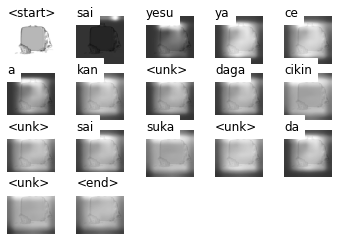

In [ ]:
checkpoint = torch.load('./BEST_checkpoint_haudata_1_cap_per_img_5_min_word_freq.pth.tar', map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

with open('./images/WORDMAP_haudata_1_cap_per_img_5_min_word_freq.json', 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}

img_path = './images/0060d23e-9692-446c-ba41-2b12791e27d0.jpg'

seq, alphas = caption_image_beam_search(encoder, decoder,img_path, word_map, 5)
alphas = torch.FloatTensor(alphas)
visualize_att(img_path, seq, alphas, rev_word_map, True)

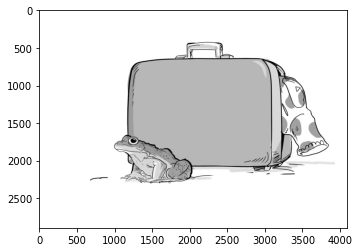

In [ ]:
img = plt.imread(img_path) 
plt.imshow(img)

In [ ]:
os.listdir('./images/')

['9ca70f78-9bd7-4e78-9624-f0d8eff33b28.jpg',
 '89c2b402-d6f2-4235-8412-54d9fb1bceb1.jpg',
 'c1885725-dcb4-46e7-b4bf-58ca822b2cc7.jpg',
 '717af8b0-d7e7-4021-a8e3-bf85739b7570.jpg',
 'cad4230e-4e6c-4f9f-8851-82be9e0be5f7.jpg',
 '3bef4ba7-f3c4-480b-9a85-04fff0eebec7.jpg',
 '2b11952e-e2e0-43e7-a0b9-dc9d79213bee.jpg',
 '44f46f3e-f888-4747-ac23-1f858cd3f368.jpg',
 'd5f371ea-36b5-4f5e-a35e-1c5aabbffe2e.jpg',
 '2c292d24-390e-4682-8292-23501c01dc50.jpg',
 '6111f216-28cf-4599-a539-4a25ea8ac432.jpg',
 '287350ec-6abe-41e5-a8f8-1b0381d11fe8.jpg',
 '1ba6375c-bbc7-4d7d-b324-152e5abc0b96.jpg',
 'e6873ad4-4312-4bed-9a3e-bbe6f9aef84c.jpg',
 '764c27d3-e22d-4da4-85aa-0fe295f548c6.jpg',
 '64a19139-c759-4bf2-be86-0ec7f1c44809.jpg',
 'aec9677d-4ec0-4303-b41b-ef4a04226100.jpg',
 '16c283c5-edcd-452a-bc65-68a650c191d8.jpg',
 '40bf7249-896b-4d6a-b762-fb1b48602870.jpg',
 'ca0aff0f-b60a-405f-a36d-25633e1c148e.jpg',
 '38834929-8df8-4445-a139-0fad8606c4b4.jpg',
 'f4bf91ef-998f-4797-a1d8-708a92e14a12.jpg',
 'a1c741df

In [ ]:
import numpy as np
import cv2
 
from pathlib import Path

imageFilesDir = Path(r'./images/')
files = list(imageFilesDir.rglob('*.jpg'))

len(files)
 
mean = np.array([0.,0.,0.])
stdTemp = np.array([0.,0.,0.])
std = np.array([0.,0.,0.])
 
numSamples = len(files)
 
for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
     
    for j in range(3):
        mean[j] += np.mean(im[:,:,j])
       
mean = (mean/numSamples)
 
print(mean) #0.51775225 0.47745317 0.35173384]

[0.77364918 0.7688241  0.73459606]


In [ ]:
for i in range(numSamples):
    im = cv2.imread(str(files[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(float) / 255.
    for j in range(3):
        stdTemp[j] += ((im[:,:,j] - mean[j])**2).sum()/(im.shape[0]*im.shape[1])
 
std = np.sqrt(stdTemp/numSamples)
 
print(std)

[0.35354225 0.35658083 0.37686874]
